# Forecasting a time series

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Intro to Time Series

### Univariate vs. Multivariate Time Series
- Univariate time series containing a sequence of one feature 
- Multivariate time series containing a sequence of multiple features

### Use Cases
1. Predicting future values of this time series
2. Imputation predicting missing values

### Conventions
- When dealing with time series we batches are normaly organized as followed: _[batch_size, time_stamps, dimensionality]_
- Univariate time series:  _[batch_size, time_stamps, 1]_
- Multivariate time series: _[batch_size, time_stamps, feature_num]_

### LSTMs and GRUs
- In this notebook we use simple RNNs Cells. 
- In praxis GRUs or LSTMs are used, because: 
    - Normal RNNs cell loss knowledge about the first inputs when handling long sequences
    - LSTMs and GRUs have a long-term memomry. The network learns what to store in the long-term memory. 

## Basic Ideas of RNN

Each Neuron (!) propagates back in time:   
    - The input will be concatenated with the hidden state _h(t)_.   
    - The first _h(t)_ = 0   
    - Afterwards the concatenated input goes trough an activation function - mostly _tanh()_
    - The output y(t) becomes the new h(t) and this happends again for n-time-stamps

<img src="../../img/1501.png" />

## Deep RNNs

<img src="../../img/1507.png" />

```python
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
```

### Notes to Deep RNN: 
1. Was zurzeit am meisten Sinn macht für mich:  
    Die Units sind die Neuronen im Netz  
    Jedes Neuron entfaltet sich, abhängig der Länge der Time Series?  
    
_Convention: # [batch_size, time steps, input dimensions]_

# Creating the time series

### Helper function for creating time serie


__What are the Time steps?__

Input Features of RNN are normally represented as [batch_size, time steps, dimensionality]

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # Creates an array of given shape (4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def plt_history(history: "history"):
    df = pd.DataFrame(history.history)
    df.plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10) # X marker
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro") # Red dot marker
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


In [5]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

### Preparing Datasets 

In [6]:
n_steps = 50
series = generate_time_series(10000, n_steps+1) # n_steps +1 generate us a label

In [7]:
series.shape # (batch_size, time steps, dimensionality)

(10000, 51, 1)

In [8]:
x_train, y_train = series[:7000, :n_steps], series[:7000, -1] # -1 takes the last time series step

In [9]:
y_train

array([[-0.26655957],
       [ 0.3220472 ],
       [ 0.26125473],
       ...,
       [-0.6304085 ],
       [ 0.14156948],
       [-0.46618882]], dtype=float32)

In [10]:
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]

In [11]:
x_test, y_test = series[9000:, :n_steps], series[:9000, -1]

## Plotting data

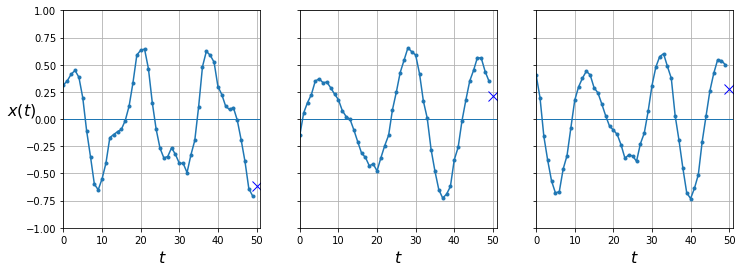

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(x_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
#save_fig("time_series_plot")
plt.show()

## Baseline Metric
Before implementing a complex RNN it's usefull first to have a baseline. 

Two options: 

__1. Naive Forecasting__  
    - Just calculate the MSE based on the validation data set
    
__2. Building a very simple model__  
    - Dense Model  
    - Linear Regression Model  
    - ...  

#### Naive Forecasting  (MSE~0.02)

In [ ]:
y_pred = x_valid[:,-1]

In [ ]:
mse = tf.keras.losses.mean_squared_error(y_pred, y_valid)

In [ ]:
np.mean(mse) 

In [ ]:
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

#### Building a Dense Model (MSE~0.004)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [n_steps, 1]),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error)

In [ ]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

In [ ]:
y_pred = model.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [ ]:
y_pred[0]

## Implementing the RNN

__return_sequences__: To output the hidden state

In [ ]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.Dense(1)
])

In [ ]:
rnn.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error)

In [ ]:
history = rnn.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

In [ ]:
y_pred = rnn.predict(x_valid)
plot_series(x_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Comparsion of Models

In [ ]:
rnn.summary()

In [ ]:
model.summary()

### Forecasting several time steps ahead

In [ ]:
pred = rnn.predict(x_test)

In [ ]:
pred.shape

In [ ]:
plt.plot(x_test[1].flatten())

In [ ]:
plt.plot(pred[1].flatten())

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
y_pred = model.predict(x_valid)[..., np.newaxis]


In [ ]:
y_train.shape

In [ ]:
x_train.shape

In [ ]:
y_train

In [ ]:
x_train[0].shape

## Multiple forecast

There are two options to forecast multiple timestamps ahead. 

__1. Option__   
    - Using the already trained model and appending iterativly the prediction to the the inputs  
    - Acting if the predicted value actually occured  
    - Predictions in the near future will be more accurate then predictions far away (Errors accumulate)  
__2. Option__  
    -  Train a separate RNN to predict all 10 next values at once

### Option 1

In [ ]:
series = generate_time_series(1, n_steps+10) # Basically one Batch?! +10 is gonna be our Y

In [ ]:
series.shape # [batch_size, time steps, input dimensions]

In [ ]:
x_new, y_new = series[:, :n_steps], series[:, n_steps:] # [batch_size, time steps, input dimensions] We wanna use those data to train the model.

In [ ]:
plt.plot(x_new[0].flatten())

In [ ]:
X = x_new
for i in range(10):
    y_pred_one = rnn.predict(x_new[:,i:]) #[batch_size, time steps, input dimensions] Give me everything from time_stamp i 
    a = y_pred_one[:, np.newaxis, :] # I don't understand why we change the shape
    X = np.concatenate([x_new, y_pred_one], axis=1) # Adding the new prediction to the dataset

In [ ]:
y_pred = X[:,n_steps:]

In [ ]:
y_new.shape

In [ ]:
y_pred.shape

In [ ]:
x_new.shape